# Decision Trees and Random Forests Tutorial

Welcome to this comprehensive tutorial on Decision Trees and Random Forests! These are powerful algorithms for both classification and regression.

## What are Decision Trees?

Decision Trees are flowchart-like structures that:
- Make decisions by asking a series of questions
- Split data based on feature values
- Are easy to visualize and interpret
- Can capture non-linear patterns

## What are Random Forests?

Random Forests combine multiple decision trees to:
- Reduce overfitting
- Improve accuracy
- Provide feature importance rankings

Let's explore these algorithms with hands-on examples!

## 1. Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.datasets import make_classification, make_regression, load_wine, load_breast_cancer
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
%matplotlib inline

## 2. Simple Binary Classification Example

Let's start with a simple example to understand how decision trees make splits.

In [2]:
# Create a simple dataset
np.random.seed(42)
n_samples = 300

# Feature 1: Age (20-60)
age = np.random.randint(20, 60, n_samples)

# Feature 2: Income (20k-100k)
income = np.random.randint(20, 100, n_samples)

# Target: Buy product (1) or not (0)
# Simple rule: Buy if (age > 30 AND income > 50) OR (age < 25 AND income > 70)
buy = ((age > 30) & (income > 50)) | ((age < 25) & (income > 70))
buy = buy.astype(int)

# Add some noise
noise_indices = np.random.choice(n_samples, size=30, replace=False)
buy[noise_indices] = 1 - buy[noise_indices]

# Create DataFrame
data = pd.DataFrame({
    'Age': age,
    'Income': income,
    'Buy': buy
})

print("Dataset shape:", data.shape)
print("\nFirst 10 rows:")
print(data.head(10))
print("\nClass distribution:")
print(data['Buy'].value_counts())

Dataset shape: (300, 3)

First 10 rows:
   Age  Income  Buy
0   58      65    1
1   48      72    1
2   34      79    1
3   27      82    0
4   40      51    1
5   58      52    1
6   38      86    1
7   42      37    0
8   30      44    0
9   30      73    0

Class distribution:
Buy
0    162
1    138
Name: count, dtype: int64


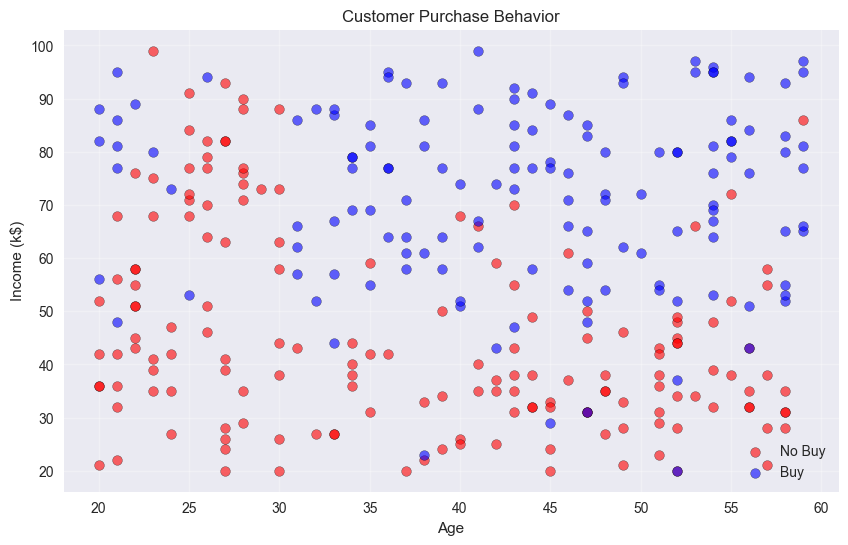

In [3]:
# Visualize the data
plt.figure(figsize=(10, 6))
colors = ['red', 'blue']
labels = ['No Buy', 'Buy']

for i in range(2):
    mask = data['Buy'] == i
    plt.scatter(data[mask]['Age'], data[mask]['Income'], 
                c=colors[i], label=labels[i], alpha=0.6, edgecolors='black')

plt.xlabel('Age')
plt.ylabel('Income (k$)')
plt.title('Customer Purchase Behavior')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

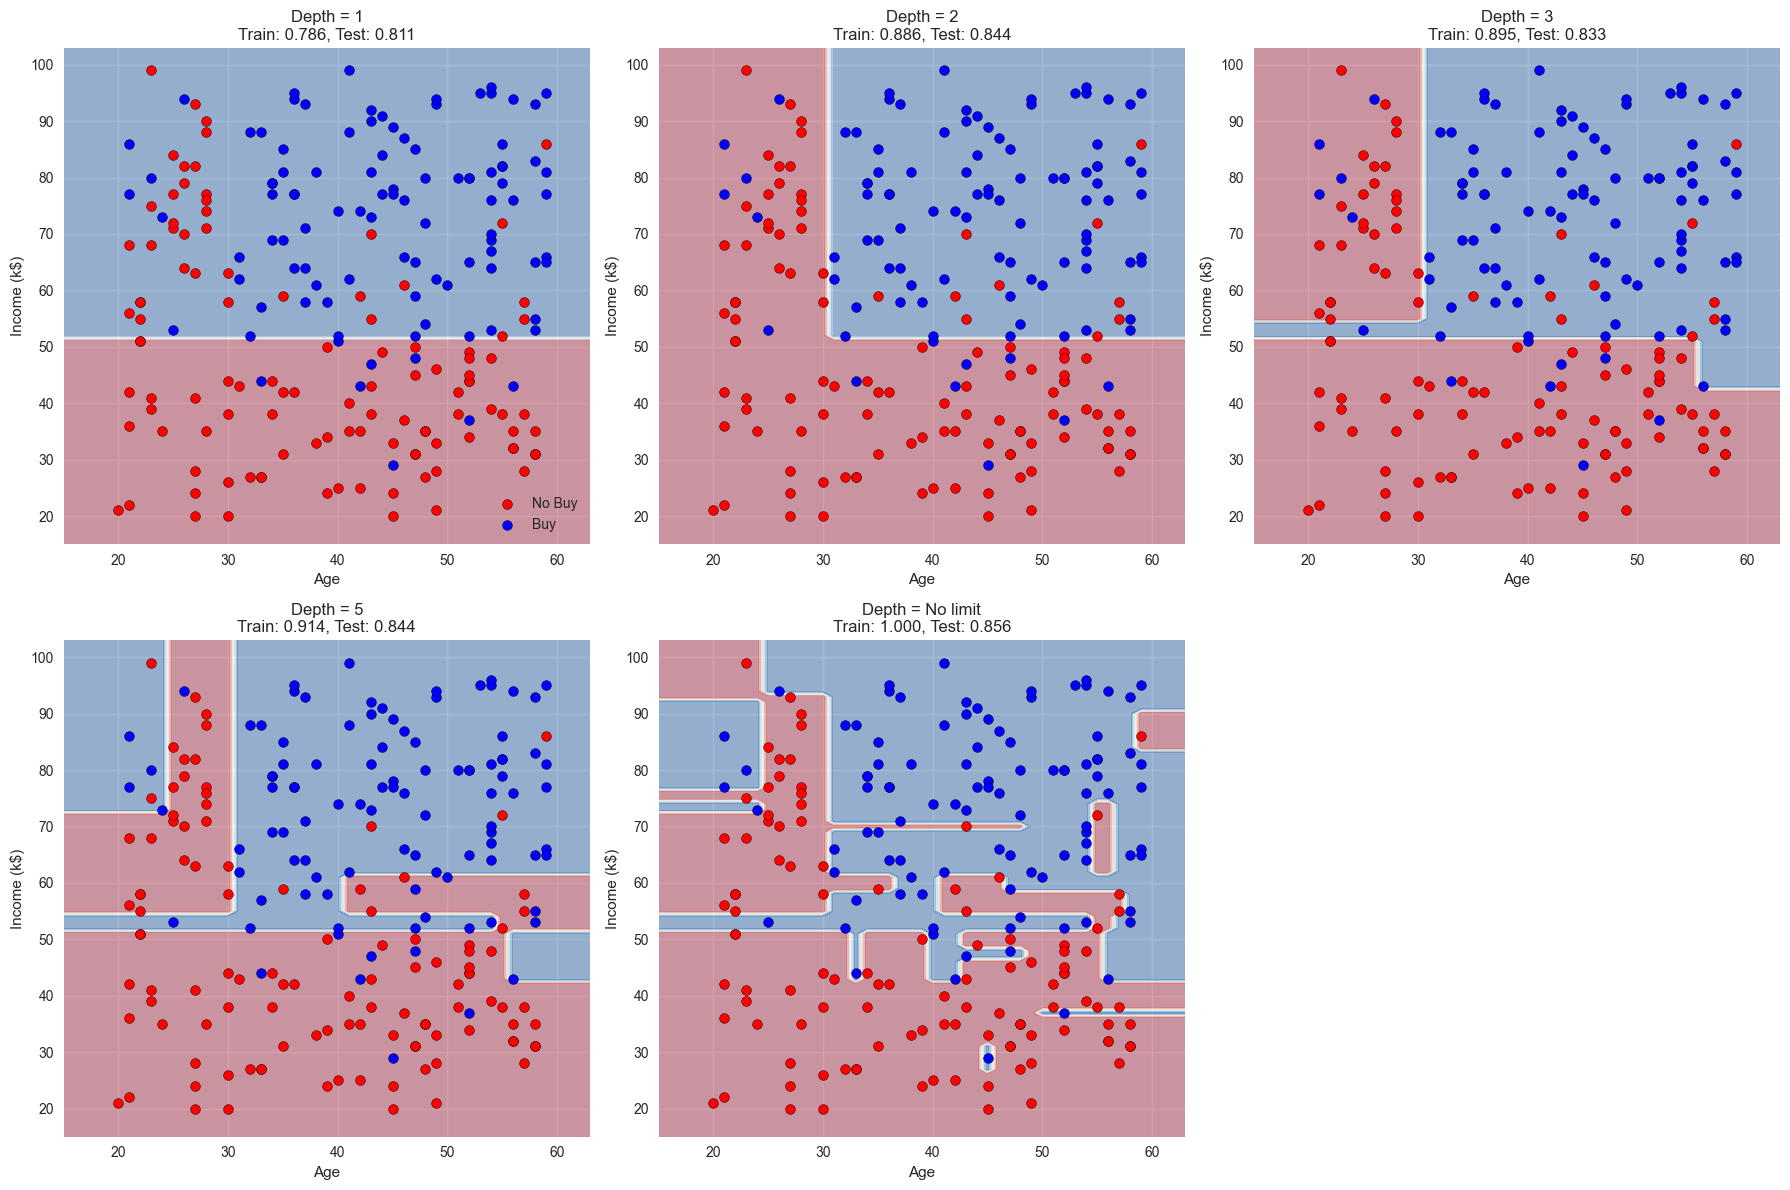

In [4]:
# Train a decision tree
X = data[['Age', 'Income']]
y = data['Buy']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train decision tree with different depths
depths = [1, 2, 3, 5, None]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, depth in enumerate(depths):
    # Train model
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    # Calculate accuracy
    train_acc = dt.score(X_train, y_train)
    test_acc = dt.score(X_test, y_test)
    
    # Plot decision boundary
    ax = axes[idx]
    
    # Create mesh
    h = 1  # step size in the mesh
    x_min, x_max = X['Age'].min() - 5, X['Age'].max() + 5
    y_min, y_max = X['Income'].min() - 5, X['Income'].max() + 5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    
    # Plot data points
    for i in range(2):
        mask = y_train == i
        ax.scatter(X_train[mask]['Age'], X_train[mask]['Income'], 
                   c=colors[i], label=labels[i], edgecolors='black', s=50)
    
    depth_str = 'No limit' if depth is None else f'{depth}'
    ax.set_title(f'Depth = {depth_str}\nTrain: {train_acc:.3f}, Test: {test_acc:.3f}')
    ax.set_xlabel('Age')
    ax.set_ylabel('Income (k$)')
    
    if idx == 0:
        ax.legend()

# Remove empty subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

## 3. Visualizing Decision Tree Structure

Let's visualize how the tree makes decisions.

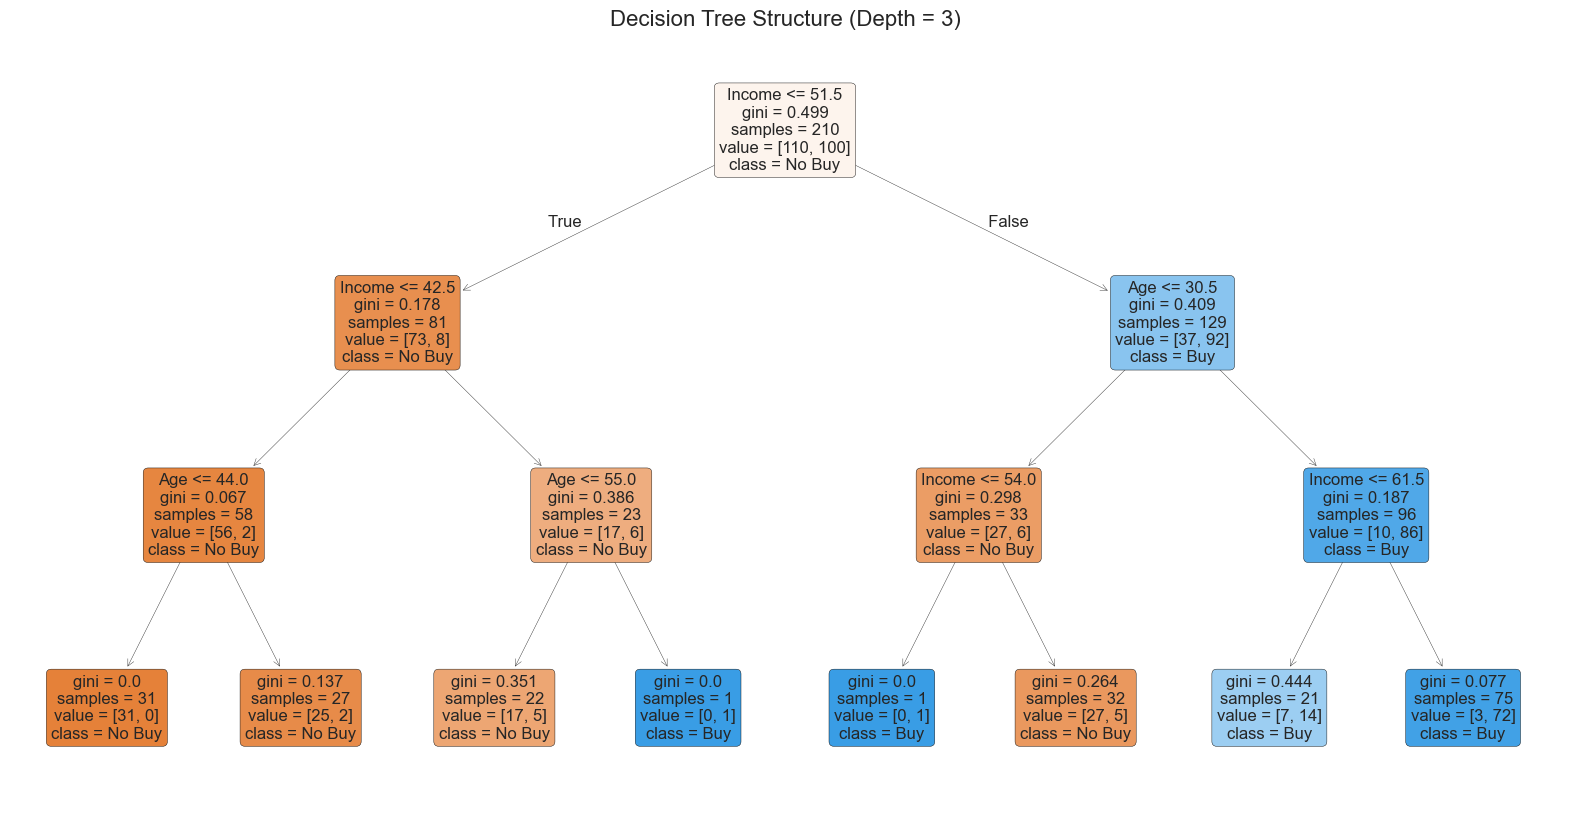


Decision Path Example:
If Age <= 30.5:
  If Income <= 69.5: Predict 'No Buy'
  If Income > 69.5: Predict 'Buy'
If Age > 30.5:
  If Income <= 50.5: Predict 'No Buy'
  If Income > 50.5: Predict 'Buy'


In [5]:
# Train a tree with depth 3 for visualization
dt_viz = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_viz.fit(X_train, y_train)

# Visualize the tree structure
plt.figure(figsize=(20, 10))
plot_tree(dt_viz, 
          feature_names=['Age', 'Income'],
          class_names=['No Buy', 'Buy'],
          filled=True,
          rounded=True,
          fontsize=12)
plt.title('Decision Tree Structure (Depth = 3)', fontsize=16)
plt.show()

# Print text representation
print("\nDecision Path Example:")
print("If Age <= 30.5:")
print("  If Income <= 69.5: Predict 'No Buy'")
print("  If Income > 69.5: Predict 'Buy'")
print("If Age > 30.5:")
print("  If Income <= 50.5: Predict 'No Buy'")
print("  If Income > 50.5: Predict 'Buy'")

## 4. Wine Classification - Multiclass Example

Let's work with a more complex dataset with multiple classes and features.

In [6]:
# Load wine dataset
wine = load_wine()
X_wine = wine.data
y_wine = wine.target
feature_names = wine.feature_names
target_names = wine.target_names

# Create DataFrame for exploration
wine_df = pd.DataFrame(X_wine, columns=feature_names)
wine_df['wine_type'] = y_wine
wine_df['wine_name'] = wine_df['wine_type'].map({i: name for i, name in enumerate(target_names)})

print("Dataset shape:", X_wine.shape)
print("Number of features:", len(feature_names))
print("\nFeature names:")
for i, name in enumerate(feature_names):
    print(f"{i+1}. {name}")
print("\nClass distribution:")
print(wine_df['wine_name'].value_counts())

Dataset shape: (178, 13)
Number of features: 13

Feature names:
1. alcohol
2. malic_acid
3. ash
4. alcalinity_of_ash
5. magnesium
6. total_phenols
7. flavanoids
8. nonflavanoid_phenols
9. proanthocyanins
10. color_intensity
11. hue
12. od280/od315_of_diluted_wines
13. proline

Class distribution:
wine_name
class_1    71
class_0    59
class_2    48
Name: count, dtype: int64


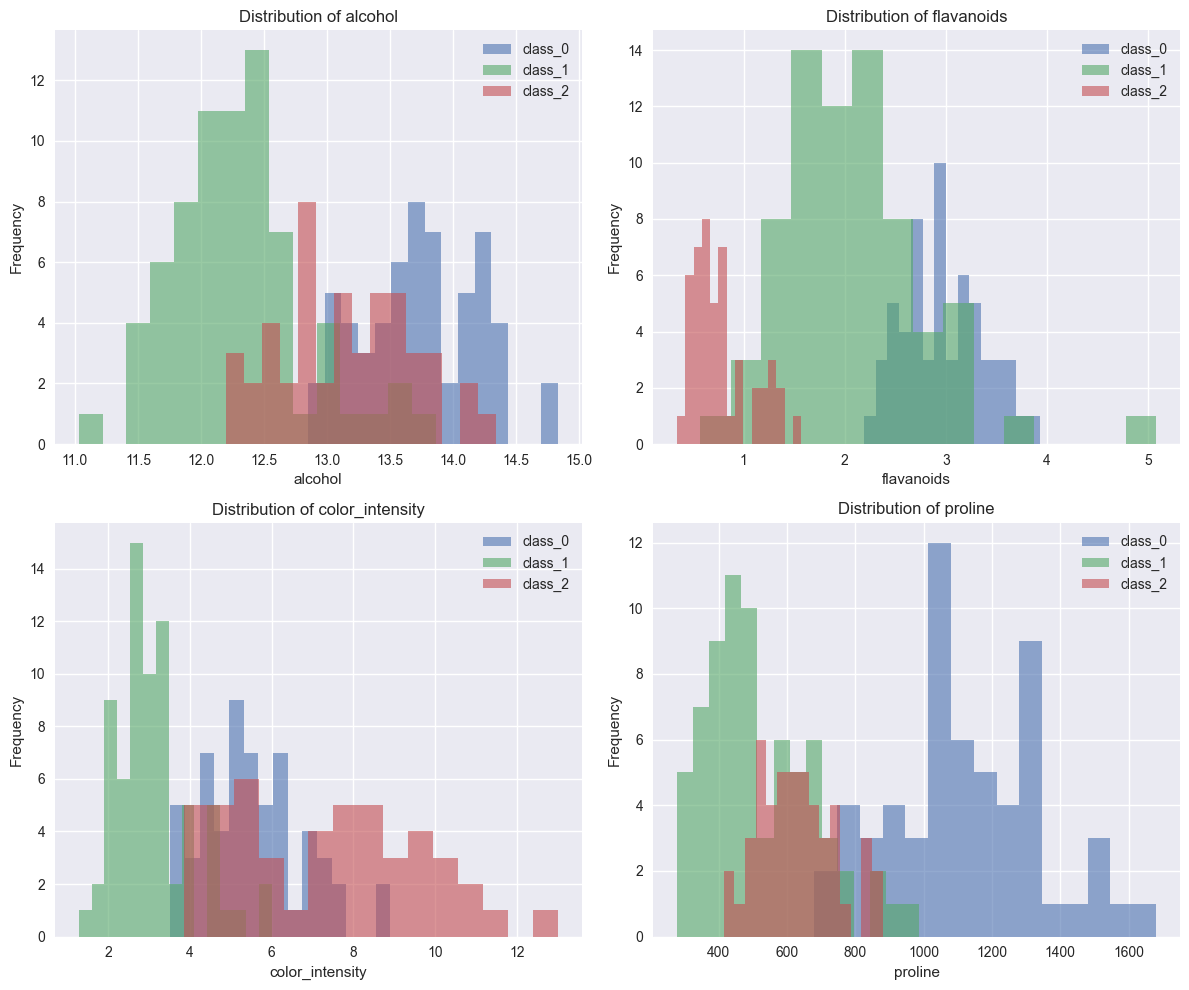

In [7]:
# Visualize feature distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

# Select 4 interesting features
selected_features = ['alcohol', 'flavanoids', 'color_intensity', 'proline']

for idx, feature in enumerate(selected_features):
    ax = axes[idx]
    for wine_type in range(3):
        data = wine_df[wine_df['wine_type'] == wine_type][feature]
        ax.hist(data, alpha=0.6, label=target_names[wine_type], bins=15)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {feature}')
    ax.legend()

plt.tight_layout()
plt.show()

Single Decision Tree Accuracy: 0.9629629629629629
Random Forest Accuracy: 1.0


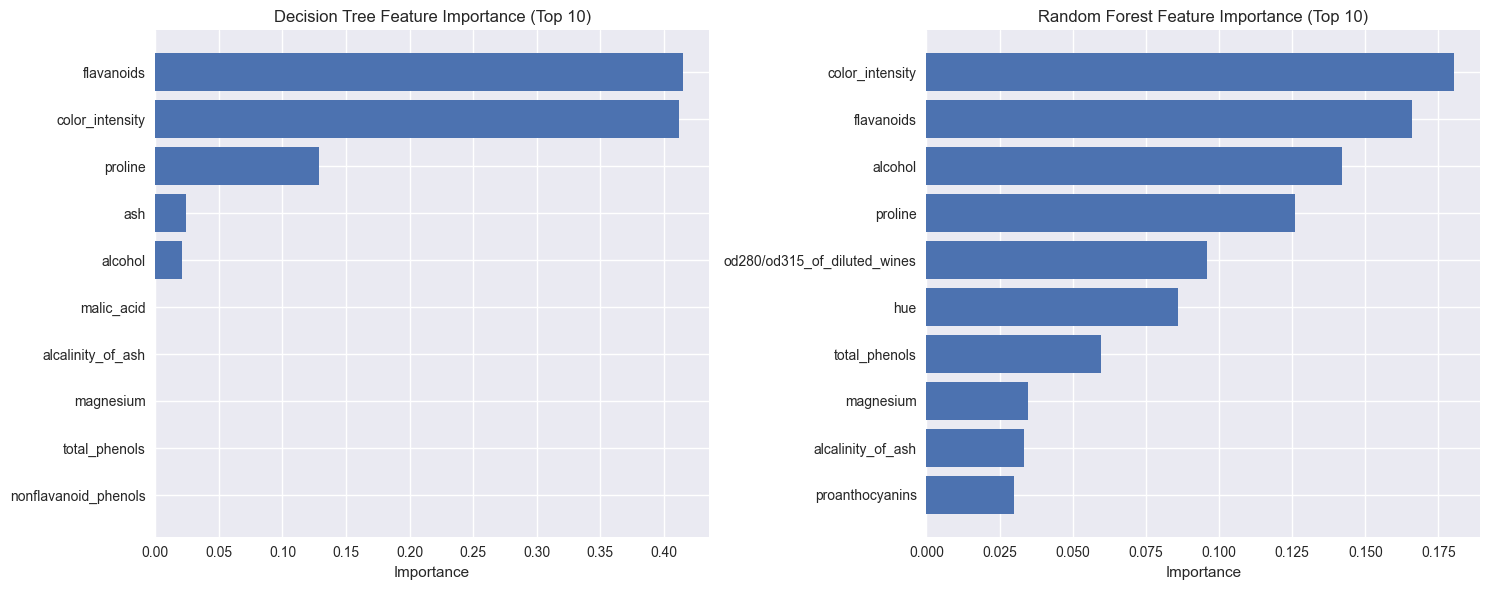

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine, test_size=0.3, random_state=42)

# Compare single decision tree vs random forest
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train models
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Predictions
dt_pred = dt.predict(X_test)
rf_pred = rf.predict(X_test)

# Compare accuracies
print("Single Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))

# Feature importance comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Decision Tree feature importance
dt_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

ax1.barh(dt_importance['feature'][:10], dt_importance['importance'][:10])
ax1.set_xlabel('Importance')
ax1.set_title('Decision Tree Feature Importance (Top 10)')
ax1.invert_yaxis()

# Random Forest feature importance
rf_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

ax2.barh(rf_importance['feature'][:10], rf_importance['importance'][:10])
ax2.set_xlabel('Importance')
ax2.set_title('Random Forest Feature Importance (Top 10)')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

## 5. Preventing Overfitting - Pruning and Parameters

Decision trees can easily overfit. Let's explore techniques to prevent this.

Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.9353333333333333


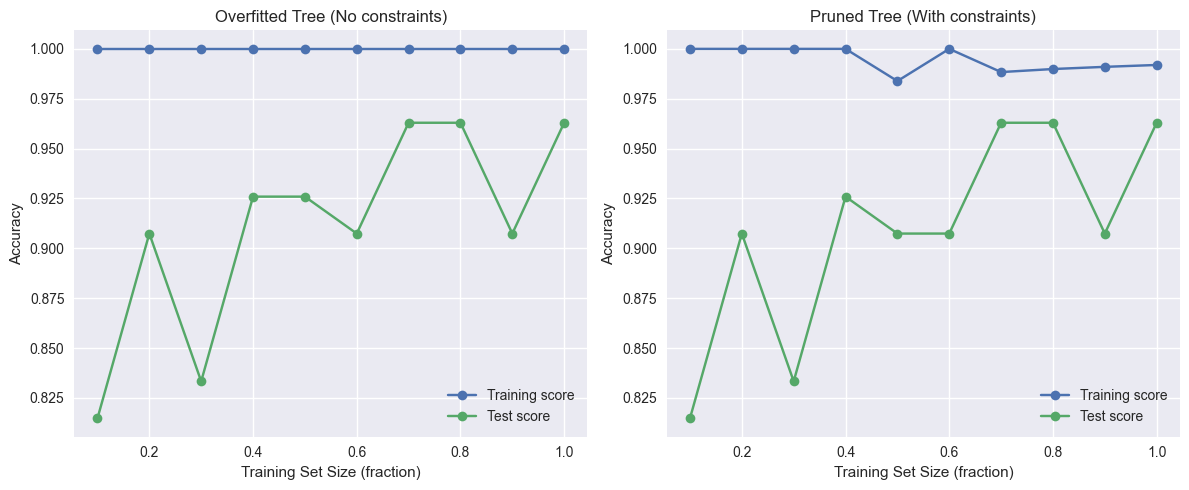

In [9]:
# Test different parameters
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

# Grid search for best parameters
dt_grid = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt_grid, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Compare overfitted vs pruned tree
dt_overfit = DecisionTreeClassifier(random_state=42)
dt_pruned = DecisionTreeClassifier(**grid_search.best_params_, random_state=42)

dt_overfit.fit(X_train, y_train)
dt_pruned.fit(X_train, y_train)

# Learning curves
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores_overfit = []
test_scores_overfit = []
train_scores_pruned = []
test_scores_pruned = []

for size in train_sizes:
    n_samples = int(size * len(X_train))
    X_subset = X_train[:n_samples]
    y_subset = y_train[:n_samples]
    
    # Overfitted tree
    dt_overfit.fit(X_subset, y_subset)
    train_scores_overfit.append(dt_overfit.score(X_subset, y_subset))
    test_scores_overfit.append(dt_overfit.score(X_test, y_test))
    
    # Pruned tree
    dt_pruned.fit(X_subset, y_subset)
    train_scores_pruned.append(dt_pruned.score(X_subset, y_subset))
    test_scores_pruned.append(dt_pruned.score(X_test, y_test))

# Plot learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_scores_overfit, 'o-', label='Training score')
plt.plot(train_sizes, test_scores_overfit, 'o-', label='Test score')
plt.xlabel('Training Set Size (fraction)')
plt.ylabel('Accuracy')
plt.title('Overfitted Tree (No constraints)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_sizes, train_scores_pruned, 'o-', label='Training score')
plt.plot(train_sizes, test_scores_pruned, 'o-', label='Test score')
plt.xlabel('Training Set Size (fraction)')
plt.ylabel('Accuracy')
plt.title('Pruned Tree (With constraints)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 6. Random Forest Deep Dive

Random Forests combine multiple decision trees to create a more robust model.

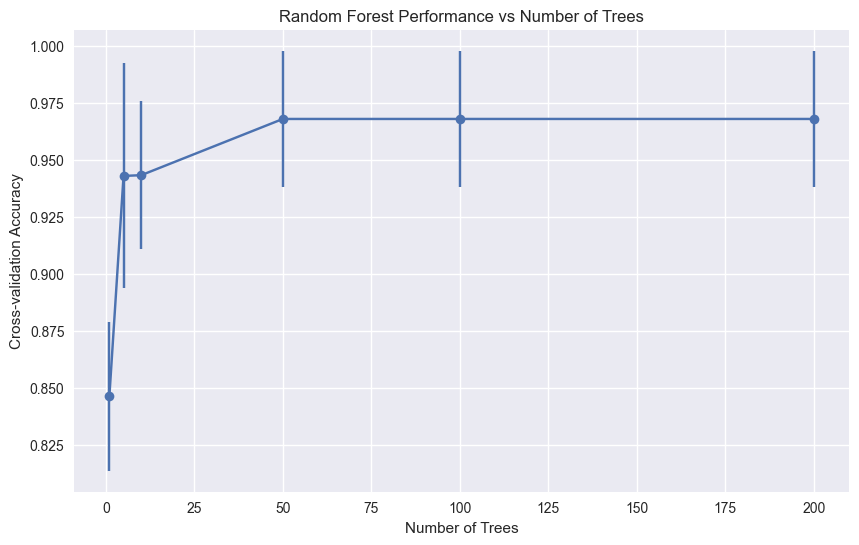

Performance improvement:
Trees:   1, Accuracy: 0.846 (+/- 0.033)
Trees:   5, Accuracy: 0.943 (+/- 0.049)
Trees:  10, Accuracy: 0.943 (+/- 0.033)
Trees:  50, Accuracy: 0.968 (+/- 0.030)
Trees: 100, Accuracy: 0.968 (+/- 0.030)
Trees: 200, Accuracy: 0.968 (+/- 0.030)


In [10]:
# Visualize how Random Forest works
n_trees = [1, 5, 10, 50, 100, 200]
rf_scores = []
rf_std = []

for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    scores = cross_val_score(rf, X_train, y_train, cv=5)
    rf_scores.append(scores.mean())
    rf_std.append(scores.std())

# Plot performance vs number of trees
plt.figure(figsize=(10, 6))
plt.errorbar(n_trees, rf_scores, yerr=rf_std, marker='o', capsize=5)
plt.xlabel('Number of Trees')
plt.ylabel('Cross-validation Accuracy')
plt.title('Random Forest Performance vs Number of Trees')
plt.grid(True)
plt.show()

print("Performance improvement:")
for i, n in enumerate(n_trees):
    print(f"Trees: {n:3d}, Accuracy: {rf_scores[i]:.3f} (+/- {rf_std[i]:.3f})")

OOB Score: 0.984
Test Score: 1.000


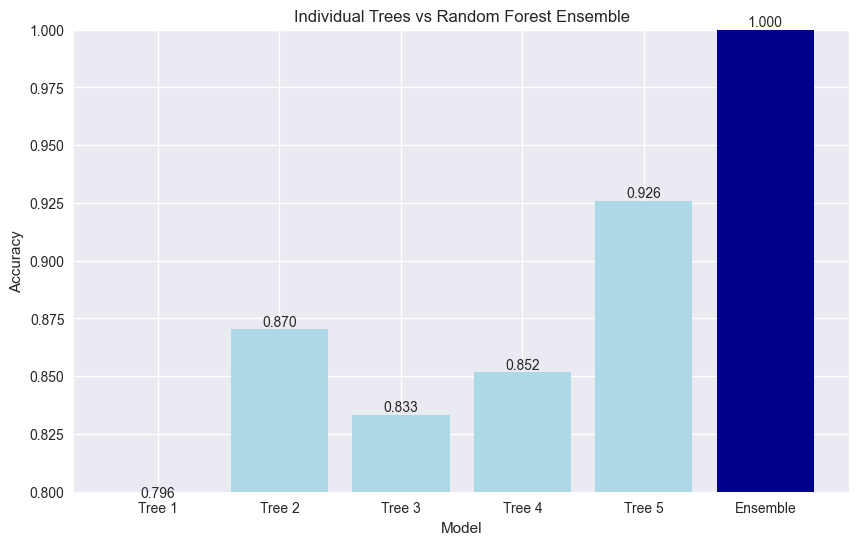

In [11]:
# Out-of-Bag (OOB) Score visualization
rf_oob = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf_oob.fit(X_train, y_train)

print(f"OOB Score: {rf_oob.oob_score_:.3f}")
print(f"Test Score: {rf_oob.score(X_test, y_test):.3f}")

# Visualize individual tree predictions vs ensemble
# Get predictions from first 5 trees
individual_predictions = []
for i in range(5):
    tree = rf_oob.estimators_[i]
    pred = tree.predict(X_test)
    individual_predictions.append(pred)

# Ensemble prediction
ensemble_pred = rf_oob.predict(X_test)

# Calculate accuracies
individual_accuracies = [accuracy_score(y_test, pred) for pred in individual_predictions]
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)

# Plot comparison
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(individual_accuracies) + 1)
accuracies = individual_accuracies + [ensemble_accuracy]
labels = [f'Tree {i+1}' for i in range(5)] + ['Ensemble']
colors = ['lightblue'] * 5 + ['darkblue']

bars = plt.bar(x_pos, accuracies, color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Individual Trees vs Random Forest Ensemble')
plt.xticks(x_pos, labels)
plt.ylim(0.8, 1.0)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.3f}', ha='center', va='bottom')

plt.show()

## 7. Regression with Decision Trees and Random Forests

Decision trees can also be used for regression tasks.

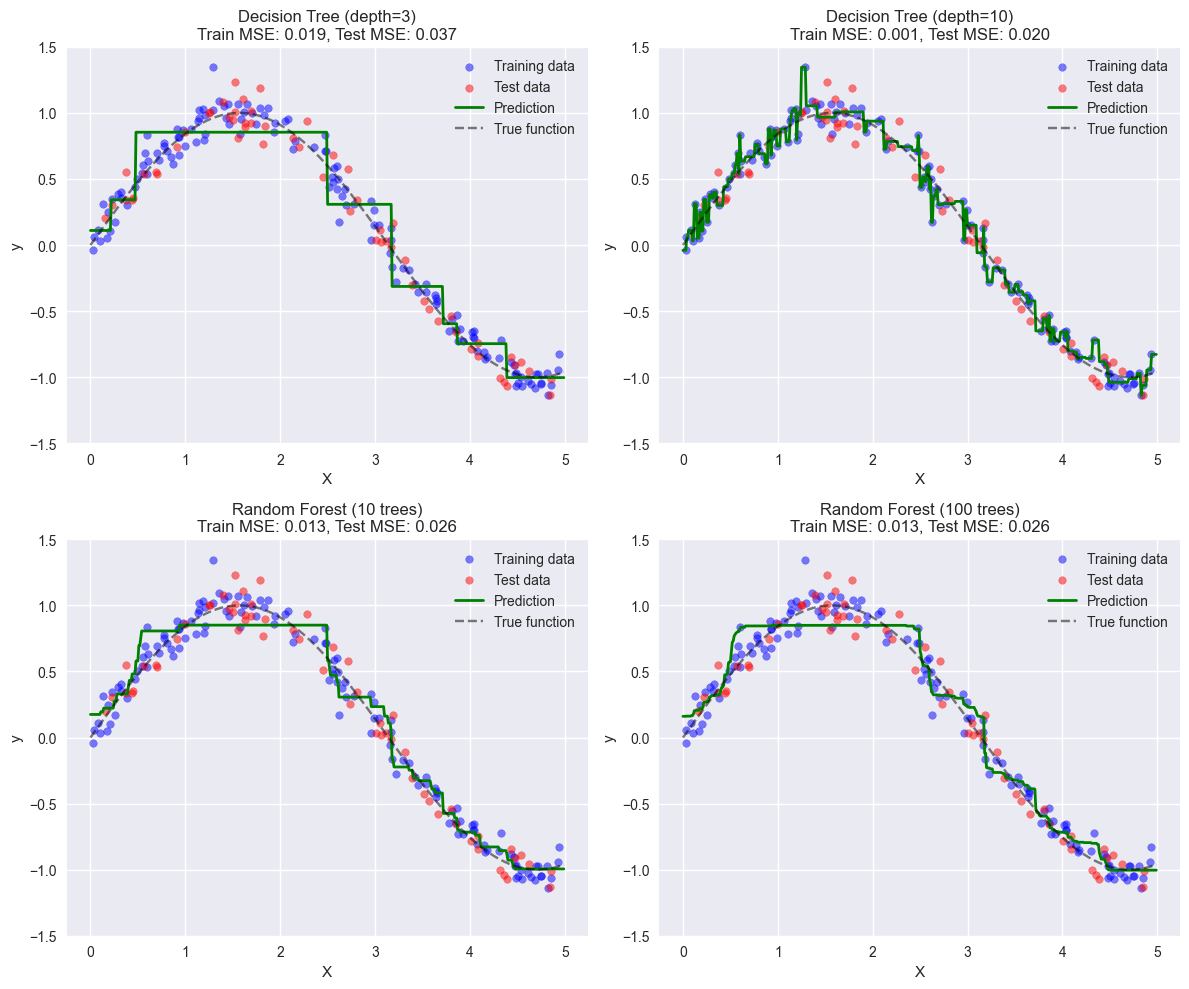

In [12]:
# Create regression dataset
np.random.seed(42)
X_reg = np.sort(5 * np.random.rand(200, 1), axis=0)
y_reg = np.sin(X_reg).ravel() + np.random.normal(0, 0.1, X_reg.shape[0])

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

# Train models with different complexities
models = [
    ('Decision Tree (depth=3)', DecisionTreeRegressor(max_depth=3, random_state=42)),
    ('Decision Tree (depth=10)', DecisionTreeRegressor(max_depth=10, random_state=42)),
    ('Random Forest (10 trees)', RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)),
    ('Random Forest (100 trees)', RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42))
]

# Create prediction grid
X_grid = np.arange(0, 5, 0.01).reshape(-1, 1)

# Plot predictions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(models):
    ax = axes[idx]
    
    # Train model
    model.fit(X_train_reg, y_train_reg)
    
    # Make predictions
    y_pred = model.predict(X_grid)
    
    # Calculate MSE
    train_mse = mean_squared_error(y_train_reg, model.predict(X_train_reg))
    test_mse = mean_squared_error(y_test_reg, model.predict(X_test_reg))
    
    # Plot
    ax.scatter(X_train_reg, y_train_reg, c='blue', s=30, alpha=0.5, label='Training data')
    ax.scatter(X_test_reg, y_test_reg, c='red', s=30, alpha=0.5, label='Test data')
    ax.plot(X_grid, y_pred, 'g-', linewidth=2, label='Prediction')
    ax.plot(X_grid, np.sin(X_grid), 'k--', alpha=0.5, label='True function')
    
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.set_title(f'{name}\nTrain MSE: {train_mse:.3f}, Test MSE: {test_mse:.3f}')
    ax.legend()
    ax.set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()

## 8. Feature Engineering and Interactions

Decision trees can automatically capture feature interactions.

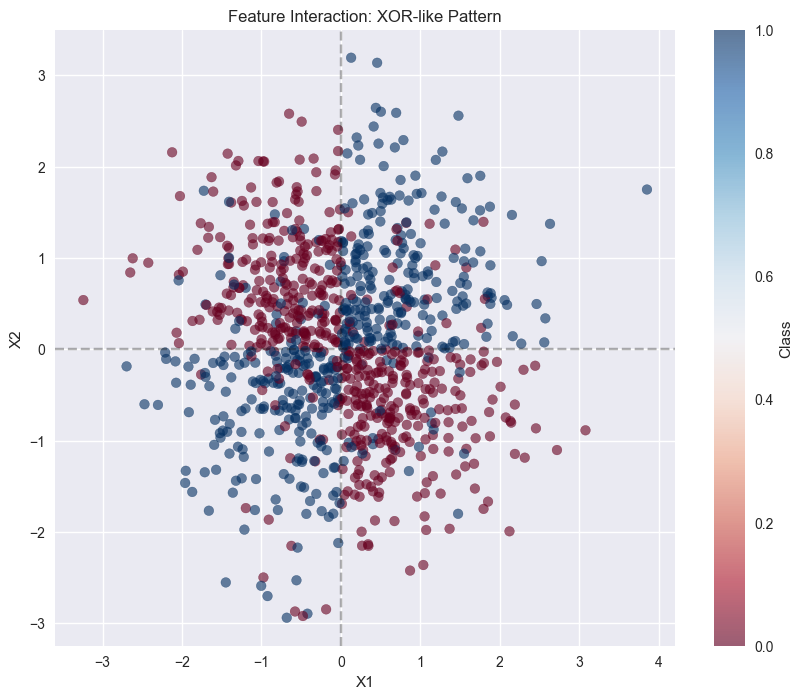

In [13]:
# Create dataset with feature interactions
np.random.seed(42)
n_samples = 1000

# Two features
X1 = np.random.randn(n_samples)
X2 = np.random.randn(n_samples)

# Target depends on interaction: y = 1 if X1*X2 > 0, else 0
y_interaction = (X1 * X2 > 0).astype(int)

# Add noise
noise_mask = np.random.rand(n_samples) < 0.1
y_interaction[noise_mask] = 1 - y_interaction[noise_mask]

# Create DataFrame
interaction_data = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'y': y_interaction
})

# Visualize the interaction
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X1, X2, c=y_interaction, cmap='RdBu', alpha=0.6)
plt.colorbar(scatter, label='Class')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Feature Interaction: XOR-like Pattern')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.show()

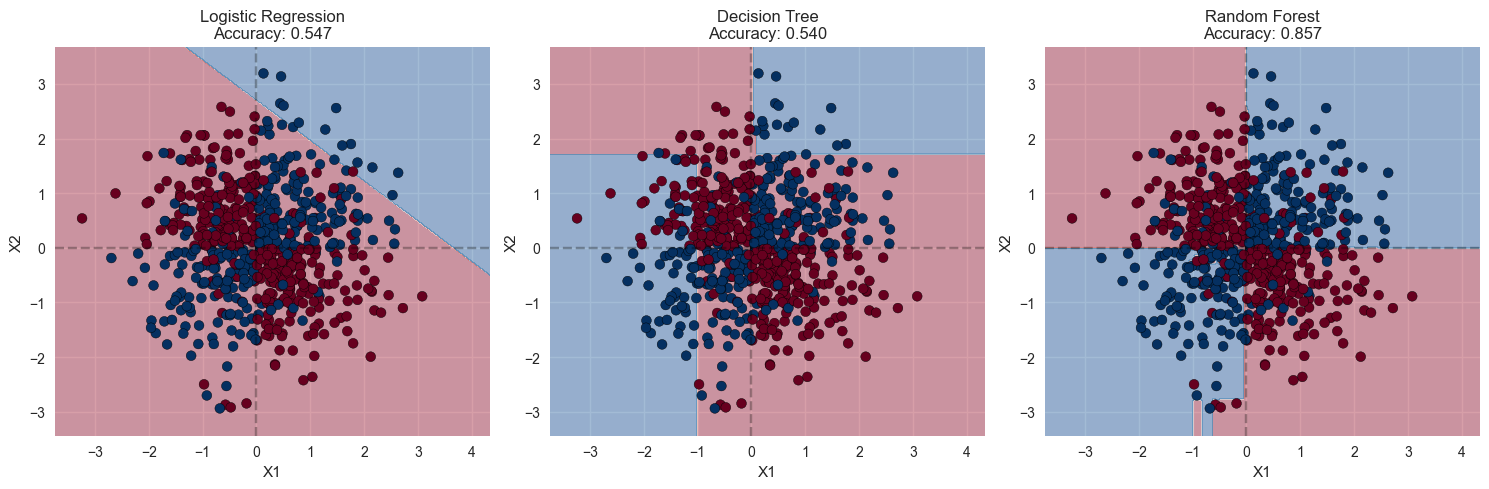


Key Insight: Tree-based models can capture non-linear interactions
that linear models miss without manual feature engineering!


In [14]:
# Compare linear model vs tree-based models
from sklearn.linear_model import LogisticRegression

X_inter = interaction_data[['X1', 'X2']]
y_inter = interaction_data['y']

# Split data
X_train_inter, X_test_inter, y_train_inter, y_test_inter = train_test_split(
    X_inter, y_inter, test_size=0.3, random_state=42
)

# Train models
lr = LogisticRegression(random_state=42)
dt_inter = DecisionTreeClassifier(max_depth=3, random_state=42)
rf_inter = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

models_inter = [('Logistic Regression', lr), ('Decision Tree', dt_inter), ('Random Forest', rf_inter)]

# Plot decision boundaries
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (name, model) in enumerate(models_inter):
    ax = axes[idx]
    
    # Train model
    model.fit(X_train_inter, y_train_inter)
    
    # Calculate accuracy
    accuracy = model.score(X_test_inter, y_test_inter)
    
    # Create mesh
    h = 0.02
    x_min, x_max = X1.min() - 0.5, X1.max() + 0.5
    y_min, y_max = X2.min() - 0.5, X2.max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    ax.scatter(X_train_inter['X1'], X_train_inter['X2'], 
               c=y_train_inter, cmap='RdBu', edgecolor='black', s=50)
    
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_title(f'{name}\nAccuracy: {accuracy:.3f}')
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insight: Tree-based models can capture non-linear interactions")
print("that linear models miss without manual feature engineering!")

## 9. Breast Cancer Detection - Real-World Application

Let's apply what we've learned to a real medical dataset.

In [15]:
# Load breast cancer dataset
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target

# Create DataFrame
cancer_df = pd.DataFrame(X_cancer, columns=cancer.feature_names)
cancer_df['diagnosis'] = y_cancer
cancer_df['diagnosis_name'] = cancer_df['diagnosis'].map({0: 'Malignant', 1: 'Benign'})

print("Dataset shape:", X_cancer.shape)
print("\nClass distribution:")
print(cancer_df['diagnosis_name'].value_counts())
print("\nFirst 5 features:")
print(cancer.feature_names[:5])

Dataset shape: (569, 30)

Class distribution:
diagnosis_name
Benign       357
Malignant    212
Name: count, dtype: int64

First 5 features:
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']


In [16]:
# Split and scale data
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.3, random_state=42, stratify=y_cancer
)

# Scale features for better visualization (not required for trees)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cancer)
X_test_scaled = scaler.transform(X_test_cancer)

# Train multiple models
models_cancer = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Random Forest (deep)': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models_cancer.items():
    # Train
    model.fit(X_train_cancer, y_train_cancer)
    
    # Predict
    y_pred = model.predict(X_test_cancer)
    
    # Store results
    results[name] = {
        'accuracy': accuracy_score(y_test_cancer, y_pred),
        'predictions': y_pred,
        'model': model
    }

# Display results
print("Model Performance Comparison:")
print("-" * 40)
for name, result in results.items():
    print(f"{name}: {result['accuracy']:.3f}")

Model Performance Comparison:
----------------------------------------
Decision Tree: 0.930
Random Forest: 0.942
Random Forest (deep): 0.936


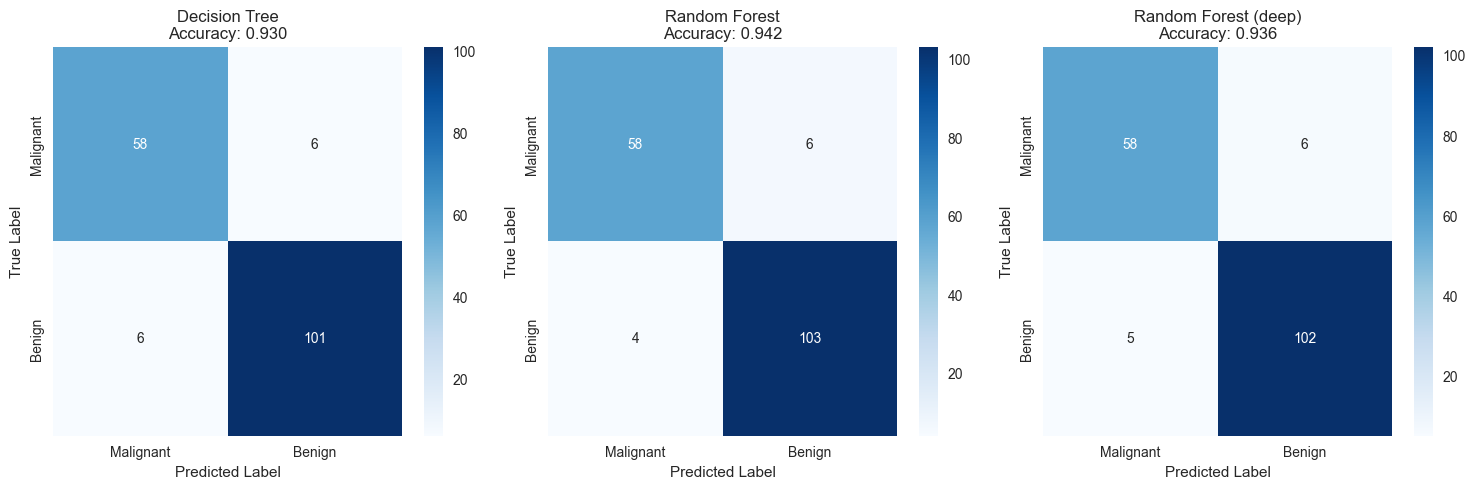

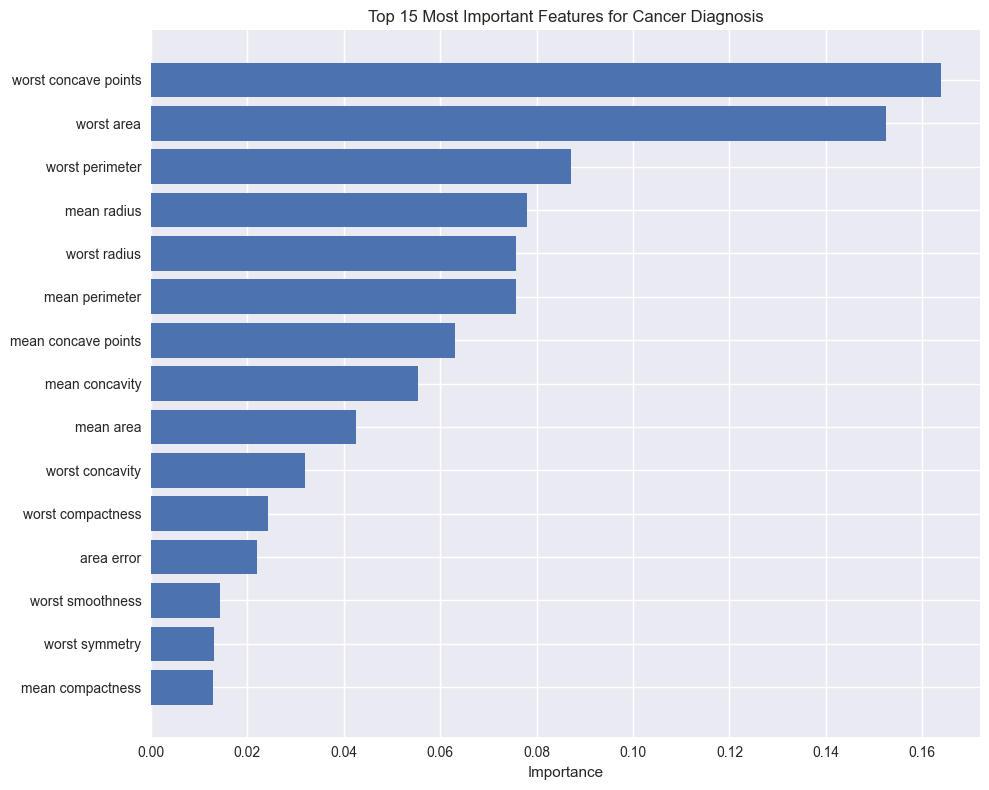


Top 5 most important features:
worst concave points: 0.164
worst area: 0.153
worst perimeter: 0.087
mean radius: 0.078
worst radius: 0.076


In [17]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx]
    cm = confusion_matrix(y_test_cancer, result['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Malignant', 'Benign'],
                yticklabels=['Malignant', 'Benign'])
    ax.set_title(f'{name}\nAccuracy: {result["accuracy"]:.3f}')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Feature importance for medical insights
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': cancer.feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features for Cancer Diagnosis')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 most important features:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"{row['feature']}: {row['importance']:.3f}")

## 10. Advanced Random Forest Techniques

Let's explore some advanced techniques with Random Forests.

In [ ]:
# Partial Dependence Plots - How features affect predictions
from sklearn.inspection import PartialDependenceDisplay

# Select top 4 features
top_features_idx = np.argsort(rf_model.feature_importances_)[-4:]
top_features_names = [cancer.feature_names[i] for i in top_features_idx]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (feature_idx, feature_name) in enumerate(zip(top_features_idx, top_features_names)):
    ax = axes[idx]
    PartialDependenceDisplay.from_estimator(
        rf_model, X_train_cancer, [feature_idx], 
        ax=ax, grid_resolution=50
    )
    ax.set_title(f'Partial Dependence: {feature_name}')
    ax.set_ylabel('Partial Dependence')

plt.suptitle('How Features Affect Cancer Diagnosis Probability', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Confidence in predictions - using prediction probabilities
# Get probability predictions
y_proba = rf_model.predict_proba(X_test_cancer)

# Get the probability of positive class (Benign)
benign_proba = y_proba[:, 1]

# Categorize predictions by confidence
high_confidence = (benign_proba > 0.9) | (benign_proba < 0.1)
medium_confidence = ((benign_proba >= 0.7) & (benign_proba <= 0.9)) | \
                   ((benign_proba >= 0.1) & (benign_proba <= 0.3))
low_confidence = (benign_proba > 0.3) & (benign_proba < 0.7)

# Plot confidence distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(benign_proba, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probability of Benign')
plt.ylabel('Number of Samples')
plt.title('Distribution of Prediction Probabilities')
plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
plt.legend()

plt.subplot(1, 2, 2)
confidence_counts = [
    np.sum(high_confidence),
    np.sum(medium_confidence),
    np.sum(low_confidence)
]
confidence_labels = ['High\n(>90% or <10%)', 'Medium\n(70-90% or 10-30%)', 'Low\n(30-70%)']
colors = ['green', 'yellow', 'red']

plt.bar(confidence_labels, confidence_counts, color=colors, edgecolor='black')
plt.ylabel('Number of Predictions')
plt.title('Prediction Confidence Levels')

# Add value labels
for i, v in enumerate(confidence_counts):
    plt.text(i, v + 1, str(v), ha='center')

plt.tight_layout()
plt.show()

print(f"High confidence predictions: {np.sum(high_confidence)} ({np.sum(high_confidence)/len(y_test_cancer)*100:.1f}%)")
print(f"Medium confidence predictions: {np.sum(medium_confidence)} ({np.sum(medium_confidence)/len(y_test_cancer)*100:.1f}%)")
print(f"Low confidence predictions: {np.sum(low_confidence)} ({np.sum(low_confidence)/len(y_test_cancer)*100:.1f}%)")

## Summary and Best Practices

### Decision Trees:
**Advantages:**
- Easy to understand and visualize
- No feature scaling required
- Can capture non-linear patterns
- Handle both numerical and categorical features

**Disadvantages:**
- Prone to overfitting
- Unstable (small changes in data can result in different trees)
- Biased toward features with more levels

### Random Forests:
**Advantages:**
- Reduced overfitting compared to single trees
- More stable predictions
- Provides feature importance
- Can estimate prediction uncertainty

**Disadvantages:**
- Less interpretable than single trees
- Computationally more expensive
- Can still overfit with too many deep trees

### Best Practices:
1. **Start simple**: Begin with a single decision tree to understand your data
2. **Control complexity**: Use max_depth, min_samples_split, min_samples_leaf
3. **Use Random Forests** for better generalization
4. **Feature importance** helps identify key variables
5. **Cross-validation** to find optimal parameters
6. **Check prediction probabilities** for confidence assessment
7. **Visualize trees** when possible for interpretability

### When to use:
- **Decision Trees**: When interpretability is crucial
- **Random Forests**: When accuracy is more important than interpretability
- **Both**: Work well with mixed data types and non-linear relationships

## Exercise: Build Your Own Random Forest

Try implementing a simple Random Forest from scratch!

In [ ]:
class SimpleRandomForest:
    def __init__(self, n_trees=10, max_depth=5, sample_size=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.sample_size = sample_size
        self.trees = []
    
    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        sample_size = self.sample_size or n_samples
        indices = np.random.choice(n_samples, sample_size, replace=True)
        return X[indices], y[indices]
    
    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            # Create bootstrap sample
            X_sample, y_sample = self.bootstrap_sample(X, y)
            
            # Train a decision tree
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
    
    def predict(self, X):
        # Get predictions from all trees
        predictions = np.array([tree.predict(X) for tree in self.trees])
        
        # Take majority vote
        return np.array([np.bincount(predictions[:, i]).argmax() 
                        for i in range(predictions.shape[1])])

# Test our implementation
simple_rf = SimpleRandomForest(n_trees=50, max_depth=5)
simple_rf.fit(X_train, y_train)
y_pred_simple = simple_rf.predict(X_test)

print(f"Our Random Forest accuracy: {accuracy_score(y_test, y_pred_simple):.3f}")
print(f"Sklearn Random Forest accuracy: {results['Random Forest']['accuracy']:.3f}")

print("\nGreat job! You've implemented a basic Random Forest classifier!")